In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv

from matplotlib import pyplot as plt
import scanpy as sc

/home/ing/miniconda3/envs/scrna/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
obs = pd.read_csv('../normal/normal_bladder_obs.csv', index_col=0, header=0)
subtype_col = 'SubType_Normal'
epithelial_types = ['Normal_Basal_Intermediate', 
                    'Normal_CDH12', 
                    'Normal_KRT7_KRT13_Basal',
                    'Normal_Umbrella_Intermediate']
obs = obs.loc[obs[subtype_col].isin(epithelial_types)]
obs.shape

(12819, 37)

In [3]:
scv.logging.print_version()

Running scvelo 0.2.2 (python 3.7.6) on 2020-09-24 10:17.


In [4]:
library = 'A'
adata = scv.read(f'normalbladder_{library}.loom', cache=True)
adata.obs_names = [f'{library}__' + x.split(":")[1][:-1] for x in adata.obs_names]
adata = adata[adata.obs_names.isin(obs.index)]
adata.obs[subtype_col] = obs[subtype_col]
adata.var_names_make_unique()
print(adata.shape)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(3000, 33538)


In [5]:
!ls ../normal/subtypes

normal_epithelial.clust.1.h5ad	    normal_immune.clust.h5ad
normal_epithelial.clust.h5ad	    normal_stromal.clust.h5ad
normal_epithelial_noCDH.clust.h5ad


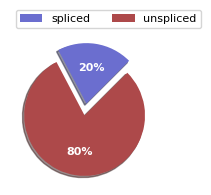

In [5]:
scv.pl.proportions(adata)

In [6]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=5000)
scv.pp.moments(adata, n_neighbors=30,)

Filtered out 27990 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 5000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [7]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

scv.tl.velocity_pseudotime(adata)
scv.tl.latent_time(adata)

recovering dynamics
    finished (0:01:46) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


saving figure to file ./figures/scvelo_normalA_2.svg


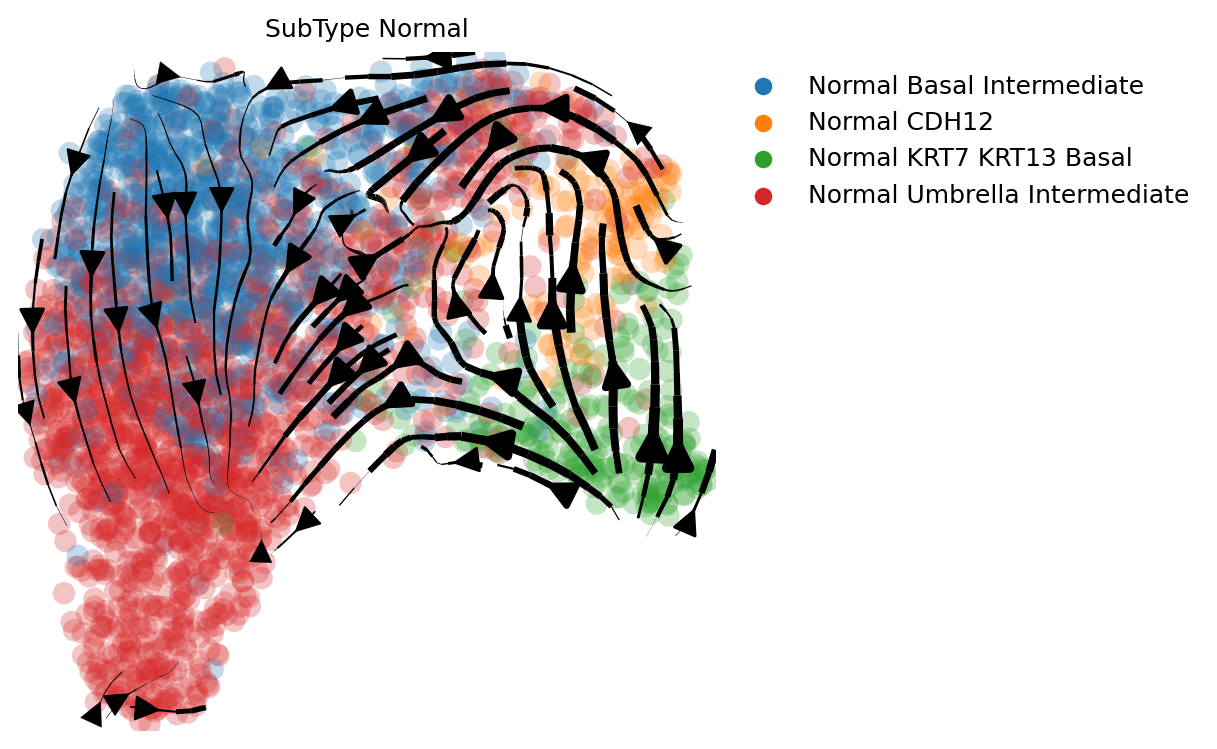

In [67]:
if 'X_umap' not in adata.obsm.keys():
    sc.tl.umap(adata)

from matplotlib import rcParams
rcParams['figure.dpi'] = 180
rcParams['figure.figsize'] = (5,5)
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color='SubType_Normal', 
                                 density = 0.5,
#                                  cutoff_perc = 20, 
#                                  min_mass = 4,
                                 linewidth=2.25,
                                 legend_loc=None,
#                                  s=75,
                                 alpha=0.27,
                                 save=f'normal{library}_2.svg'
#                                  arrowsize=4,
                                )

In [13]:
scv.tl.rank_velocity_genes(adata, groupby='SubType_Normal', min_corr=.3)

ranking velocity genes
    finished (0:00:03) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [14]:
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df

,Normal_Basal_Intermediate,Normal_CDH12,Normal_KRT7_KRT13_Basal,Normal_Umbrella_Intermediate
0,ZBTB16,NCKAP1L,EPHA7,AC121764.1
1,ELF3,GPRC5A,TPM1,ADAM22
2,SLC20A1,ASB5,TBX2,ID2
3,GDF15,NEXN,COL3A1,SHH
4,SCN11A,PRUNE2,SPARCL1,THBS2
...,...,...,...,...
95,COL4A2,KRT17,PKHD1,NCKAP1L
96,DCN,RPS14,RPL7A,FILIP1
97,NEXN,FAU,OVOL1,GADD45B
98,ASB5,NR4A1,QSOX1,PALLD


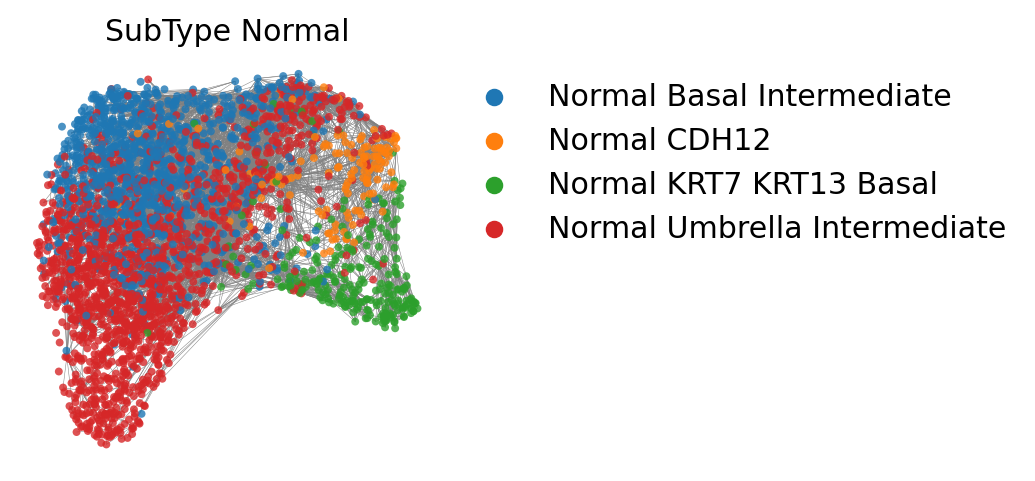

In [16]:
rcParams['figure.dpi'] = 180
rcParams['figure.figsize'] = (3,3)
scv.pl.velocity_graph(adata, threshold=0.5, color='SubType_Normal')

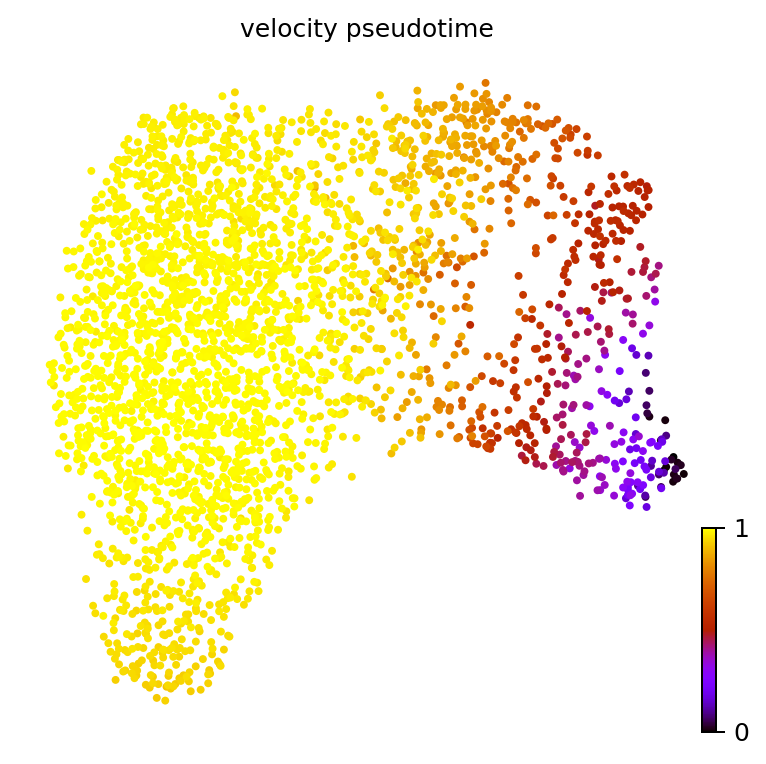

In [11]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
saving figure to file ./figures/scvelo_latent_time_normalA.svg


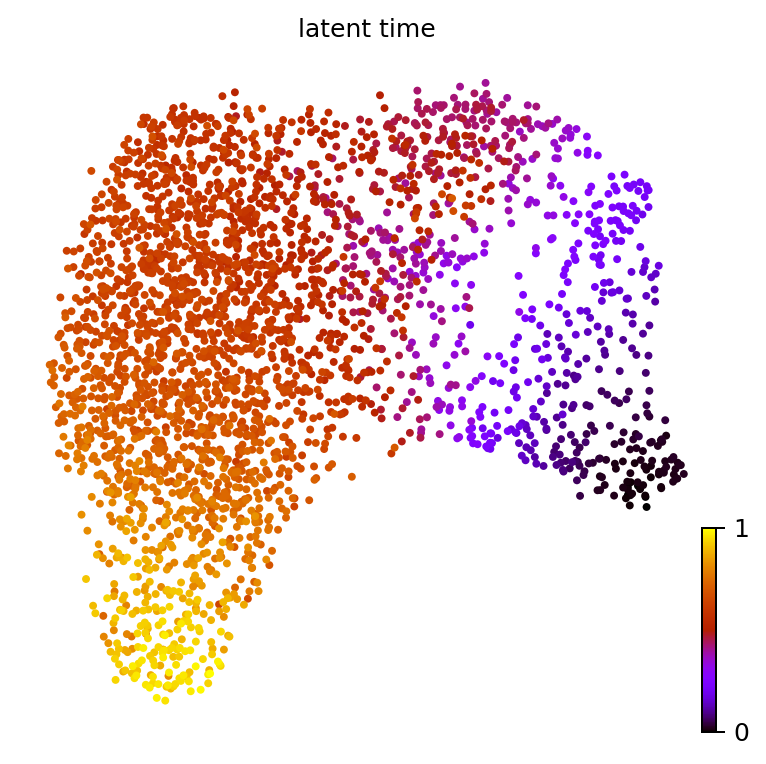

In [12]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', cmap='gnuplot', save=f'latent_time_normal{library}.svg')

In [19]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:500]
print(top_genes)

Index(['NEAT1', 'DHRS2', 'SCUBE2', 'TOB1', 'ELF3', 'WNT5A', 'LAMB1', 'PLCE1',
       'THBS2', 'RPL28',
       ...
       'LYST', 'NID1', 'ERO1B', 'HEATR1', 'CEP170', 'ADSS', 'HNRNPU', 'SMYD3',
       'AHCTF1', 'ZNF692'],
      dtype='object', length=500)


In [14]:
rcParams['font.size'] = 2
rcParams['figure.dpi'] = 600
marker_genes = [
    'CD44', 'CDH3', 'KRT16', 
    'KRT6A', 'KRT6B', 'KRT6C',
    'KRT1', 'KRT13', 'KRT5', 'KRT17',
    'KRT14', 'KRT20', 'UPK1A', 'UPK1B', 'UPK2',
    'UPK3A', 'UPK3B', 'PPARG', 'GATA3',
    'KRT7', 'KRT8', 'KRT18', 'KRT19'
]
ax = scv.pl.heatmap(adata, var_names=marker_genes, 
                    sortby='latent_time', 
                    col_color='SubType_Normal', 
                    layer='Mu',
                    n_convolve=50, 
#                font_scale=0.2,
                    color_map='magma',
                    figsize=(6,1),                
                    colorbar=True, 
                    show=False,
                    yticklabels=True, 
                    save = f'_normal{library}_selectedGenes_Mu.svg'
              )

saving figure to file ./figures/scvelo_heatmap__normalA_selectedGenes_Mu.svg
